In [1]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
#Load the data
extension = "cp_trajABC"
print(f"-------------------------------- Load M {extension} --------------------------------")
name_experiment = "playground_metropolis_" + extension
path_start = "../outputs/" + name_experiment + "/"
lst_data = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data.append(json.load(file))
                    print("Loaded: " + path)

-------------------------------- Load M cp_trajABC --------------------------------
Loaded: ../outputs/playground_metropolis_cp_trajABC/2024-09-19/22-05-40_442/all.json
Loaded: ../outputs/playground_metropolis_cp_trajABC/2024-09-19/22-07-08_443/all.json


In [3]:
# Reconstruct all rules M
all_rules = []
all_likelihoods = []
all_weights = []
all_prev_rules_ind = []
for data in lst_data:
    nb_particles = data["metrics"]["nb_rules"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["metrics"]["test_likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules = np.concatenate(all_rules, axis=0)
all_likelihoods = np.concatenate(all_likelihoods, axis=0)
all_weights = np.concatenate(all_weights, axis=0)
all_prev_rules_ind = np.concatenate(all_prev_rules_ind, axis=0)

# Print rules

In [4]:
# Compare best rule for Metropolis
# Best rules for each seed
best_taken = 1000
best_rules_ind_seed = np.argsort(-all_likelihoods, axis=1)[:,:best_taken]
best_rules = np.take_along_axis(all_rules, best_rules_ind_seed, axis=1)
best_likelihoods = np.take_along_axis(all_likelihoods, best_rules_ind_seed, axis=1)
best_rules_ind = np.argsort(-best_likelihoods.flatten())
for incr, ind in enumerate(best_rules_ind):
    seed = ind % all_rules.shape[0]
    unravel_ind = np.unravel_index(ind, best_rules.shape)
    print(
        f"-----rule-----:{incr}({seed}): {repr(best_rules[unravel_ind])}, likelihood: {best_likelihoods[unravel_ind]:2f}"
    )

-----rule-----:0(3): '1. Go to the water. (You are standing on the water.)\n2. Pick up the object. (You are holding the water.)\n3. Go to a bean seed. (You are standing on the bean seed.)\n4. Give the water. (The water and bean seed transform into the bean.)\n5. Pick up the object. (You are holding the bean.)\n6. Go to the water. (You are standing on the water.)\n7. Pick up the object. (You are holding the bean and the water.)\n8. Go to a pea seed. (You are standing on the pea seed.)\n9. Give the water. (The water and pea seed transform into the pea.)\n10. Pick up the object. (You are holding the bean and the pea.)\n11. Go to the baby giraffe. (You are standing on the baby giraffe.)\n', likelihood: -190.038956
-----rule-----:1(4): '1. Pea Rule:\n   a. Go to the water (o: You are standing on the water.)\n   b. Pick up the object (o: You are holding the water.)\n   c. Go to the pea seed (o: You are standing on the pea seed.)\n   d. Give the water (o: The water and pea seed transform into

# Individual Analysis

## Metropolis analysis


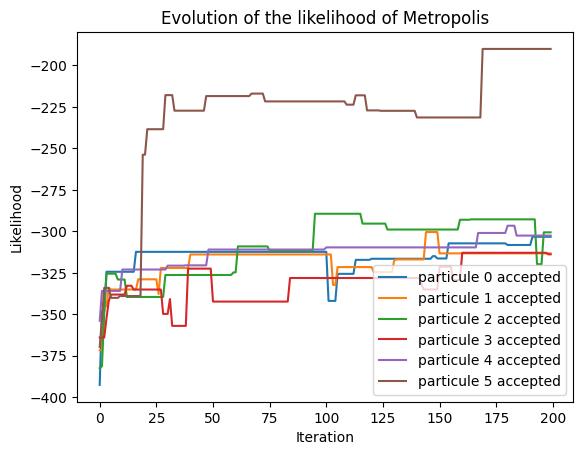

In [5]:
plt.figure()
for seed in range(all_rules.shape[0]):
    plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis")
plt.show()


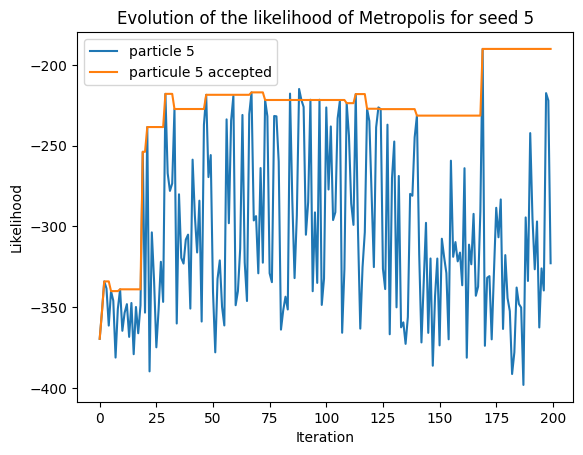

In [6]:
seed = 5
plt.figure()
plt.plot(all_likelihoods[seed, :-1], label="particle "+ str(seed))
plt.plot(all_likelihoods[seed,all_prev_rules_ind[seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title("Evolution of the likelihood of Metropolis for seed " + str(seed))
plt.show()


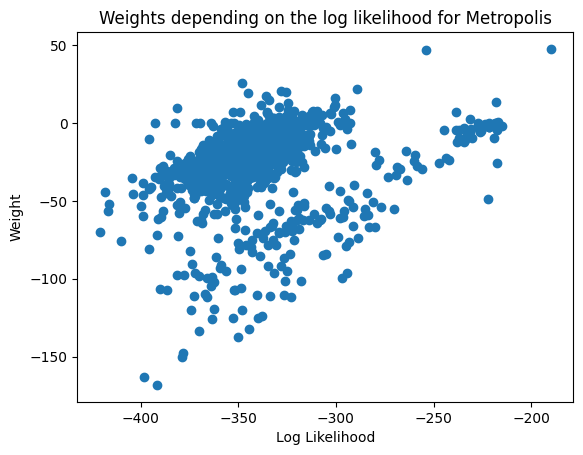

In [7]:
# Evolution of the weights depending on the likelihood
plt.figure()
plt.scatter(all_likelihoods.flatten(), all_weights.flatten())
plt.xlabel("Log Likelihood")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood for Metropolis")
plt.show()


Text(0.5, 1.0, 'Weights depending on the log likelihood difference')

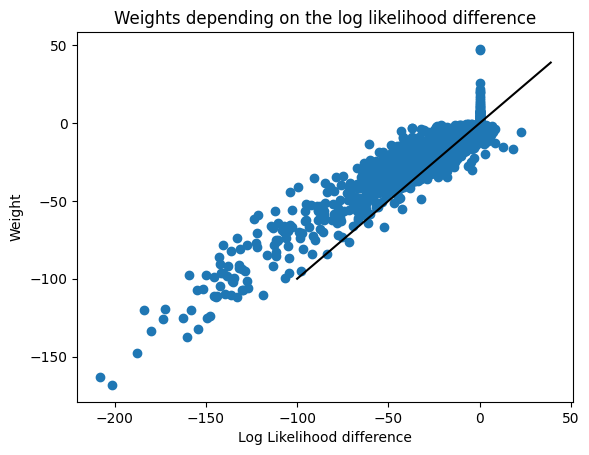

In [8]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight")
plt.title("Weights depending on the log likelihood difference")

Text(0.5, 1.0, 'Difference of weights depending on the log likelihood difference')

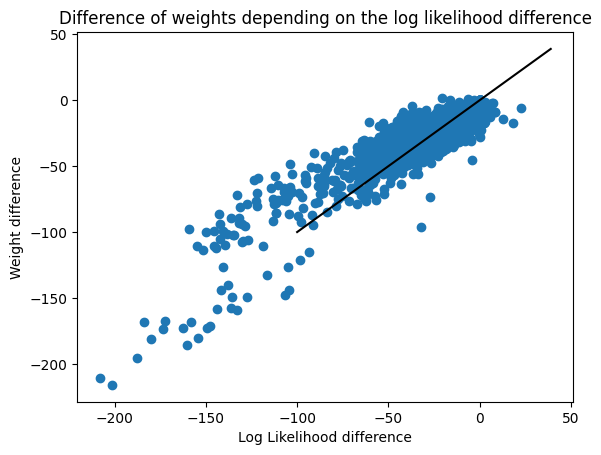

In [9]:
#Compute difference between rule and previous rule
# Find the position of the gloabl array given the branch and branch index
_index = np.arange(all_likelihoods.shape[0]).repeat(all_likelihoods.shape[1]-1).reshape((all_likelihoods.shape[0], all_likelihoods.shape[1]-1))
plt.figure()
plt.scatter(all_likelihoods[:,:-1]- all_likelihoods[_index, all_prev_rules_ind[:,1:]], all_weights[:,:-1] - all_weights[_index, all_prev_rules_ind[:,1:]])
plt.plot(np.arange(-100,40),np.arange(-100,40), color="black")
plt.xlabel("Log Likelihood difference")
plt.ylabel("Weight difference")
plt.title("Difference of weights depending on the log likelihood difference")

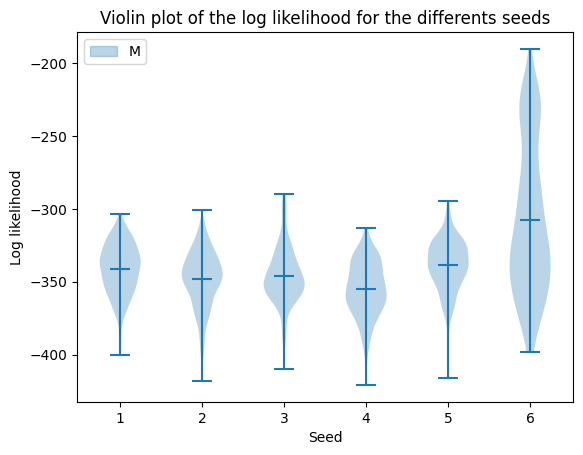

In [10]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_m = plt.violinplot(all_likelihoods.transpose(), showmeans=True)["bodies"][0].get_facecolor().flatten()
color_m = matplotlib.patches.Patch(color=color_m)
plt.legend([color_m], ["M"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()